In [101]:
import numpy as np
from scipy.linalg import eigh
import urllib.request
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from tqdm import tqdm 

In [102]:
def load_uci_digits():
    # 数据集URL地址（官网数据）
    base_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mfeat/"
    files = ["mfeat-fou", "mfeat-fou", "mfeat-kar", "mfeat-pix", "mfeat-zer", "mfeat-mor"]

    views = []
    for file in ["mfeat-fac", "mfeat-fou", "mfeat-kar", "mfeat-pix", "mfeat-zer", "mfeat-mor"]:
        url = base_url + file
        response = urllib.request.urlopen(url)
        data = response.read().decode('utf-8').strip().split('\n')
        view = np.array([list(map(float, line.strip().split())) for line in data])
        view = view[:2000, :]  # 只取前2000个样本（每个类别200个，共10个类别）
        views.append(view)

    return views

# 加载数据
views = list(load_uci_digits())
for idx, view in enumerate(views):
    print(f"View {idx+1} shape:", view.shape)

View 1 shape: (2000, 216)
View 2 shape: (2000, 76)
View 3 shape: (2000, 64)
View 4 shape: (2000, 240)
View 5 shape: (2000, 47)
View 6 shape: (2000, 6)


In [103]:
views = load_uci_digits()
X1, X2, X3, X4, X5, X6 = views

## 对下文代码中选择使用project to simplex的叙述

在算法中，每一列 $s_j$（表示与数据点 $j$ 的相似性权重）需要满足以下两个约束条件：

1. **非负性约束**：每个 $ s_{ij} \geq 0 $。  
   这确保了相似性不能为负，符合直觉和实际意义（相似性通常是一个非负值）。

2. **归一化约束**：所有权重的和为 1，即  
   $
   \sum_i s_{ij} = 1.
   $
   这使得每个 $ s_j$ 可以看作一个概率分布，反映数据点 $j$ 与其他数据点之间相似性的相对比例。

由于这两个约束，更新 $s_j$  的问题实际上就转化为一个带有约束的优化问题：在某种损失函数下，找到最优的 $ s_j$。该优化问题可以转化为**将一个向量投影到概率单纯形上**的问题。这样做的原因包括：

- **实现约束条件的满足**：  
  通过投影，将任意得到的向量（这里是 $-\frac{g_j}{2\beta}$映射到满足非负性和归一化约束的概率单纯形上，从而保证更新后的 $ s_j$ 合法。

- **提高数值稳定性**：  
  利用单纯形投影可以避免在数值计算过程中出现负值或过大/过小的权重，从而提高整个算法的稳定性。

- **简化优化过程**：  
  单纯形投影有现成的高效算法（例如，参考 Projection onto the probability simplex 的方法），使得我们可以直接对得到的向量进行处理，而不必显式地引入拉格朗日乘子反向求解，从而简化了实现过程。

综上所述，投影到单纯形上不仅能够满足问题对 $ s_j $ 的约束条件，还能暴露数据的结构特性，为后续利用这个相似性矩阵构造图拉普拉斯矩阵和获得合适的谱嵌入 $ Q $提供有力支持。

## Single View准备工作

In [104]:
def project_simplex(v):
    """
    将向量 v 投影到概率单纯形上，即：
       w = argmin_{w} ||w - v||^2,  s.t. sum(w)=1,  w >= 0.
    参考论文: Wang & Carreira-Perpinan (2013) "Projection onto the probability simplex".
    """
    n = len(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u + (1 - cssv) / (np.arange(n) + 1) > 0)[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    w = np.maximum(v - theta, 0)
    return w

def compute_laplacian(S):
    D = np.diag(S.sum(axis=1))
    L = D - S
    return L

def update_S(Q, beta):
    n, c = Q.shape
    S = np.zeros((n, n))
    # 预先计算所有点之间的欧氏距离的平方（针对嵌入 Q）
    # Q_norms 是长度为 n 的向量， q_i^2
    Q_norms = np.sum(Q**2, axis=1, keepdims=True)
    # dist_sq[i,j] = ||q_i - q_j||^2 = ||q_i||^2 + ||q_j||^2 - 2 q_i^T q_j.
    dist_sq = Q_norms + Q_norms.T - 2 * np.dot(Q, Q.T)
    # 保证非负数
    dist_sq = np.maximum(dist_sq, 0)
    
    for j in range(n):
        # 对于第 j 列（对应数据点 j）
        g_j = dist_sq[:, j]
        # 计算辅助向量 v = - g_j/(2*beta)
        v = -g_j / (2 * beta)
        # 投影到概率单纯形
        s_j = project_simplex(v)
        S[:, j] = s_j
        
    return S

def update_Q(L, c):
    """
    对于对称拉普拉斯矩阵 L（大小 n x n），获取最小 c 个特征值对应的特征向量，
    构成嵌入矩阵 Q（大小 n x c）。
    使用 scipy.linalg.eigh 默认返回的特征值按升序排序。
    """
    # eigh保证L为对称矩阵
    eigvals, eigvecs = eigh(L)
    Q = eigvecs[:, :c]
    return Q, eigvals

In [106]:
def make_single_view_graph(single_view_graph_X, class_number, default_beta=1.0):
    
    single_view_graph = []
    
    for i in tqdm(range(len(single_view_graph_X))):
        
        X_kpca = single_view_graph_X[i]
        
        # init
        beta = default_beta
        S = update_S(X_kpca, beta)
        S = (S + S.T) / 2
        L = compute_laplacian(S)
        Q, eigvals = update_Q(L, class_number)

        for j in range(100):
            S = update_S(Q, beta)
            S = (S + S.T) / 2
            L = compute_laplacian(S)
            Q_new, eigvals = update_Q(L, c)

        if np.linalg.norm(Q - Q_new, 'fro') / np.linalg.norm(Q, 'fro') < 1e-4:
            tqdm.write(f"{i}th graph end at {j}th iteration, smallest eigenvalues: {eigvals[:c]}")
            break
        Q = Q_new
        num_zero_eig = np.sum(eigvals < 1e-5)
        if num_zero_eig >= c:
            tqdm.write(f"Converged: the Laplacian has {num_zero_eig} (>= {c}) zero eigenvalues.")
            break
        single_view_graph.append(S)
        
    return single_view_graph

### 使用了Jiahao的代码来看效果

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate two-moon datasets
graph_number = 10
single_view_graph_X = []
for i in range(graph_number):
    X, y = make_moons(n_samples=100, noise=0.05, random_state=i+10)
    single_view_graph_X.append(X)

In [108]:
class_number = 2

single_view_graph = make_single_view_graph(single_view_graph_X, class_number)

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


In [109]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from matplotlib.colors import ListedColormap


def plot_clusters_multi(X_list, S_list, n_nearest=5):
    # Ensure the input lists are of the same length
    assert len(X_list) == len(S_list), "X_list and S_list must have the same number of elements"
    
    n_datasets = len(X_list)
    rows = int(np.ceil(np.sqrt(n_datasets)))
    cols = int(np.ceil(n_datasets / rows))
    
    plt.figure(figsize=(6 * cols, 4 * rows))
    
    for idx in range(n_datasets):
        X = X_list[idx]
        S = S_list[idx]
        
        # Perform spectral clustering
        model = SpectralClustering(n_clusters=2, affinity='precomputed',
                                   assign_labels='discretize', random_state=42)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", 
                message="Array is not symmetric, and will be converted to symmetric*")
            warnings.filterwarnings("ignore",
                message="Graph is not fully connected, spectral embedding*")
            clusters = model.fit_predict(S)
        
        # Compute nearest neighbor connections
        n = X.shape[0]
        D = np.linalg.norm(X[:, np.newaxis, :] - X, axis=2)
        S_new = np.zeros((n, n), dtype=int)
        for i in range(n):
            nearest_neighbors = np.argsort(D[i])[1:n_nearest+1]
            S_new[i, nearest_neighbors] = 1
        
        # Create subplot
        plt.subplot(rows, cols, idx + 1)
        colors = ['blue', 'red']
        cmap = ListedColormap(colors)
        
        # Plot data points
        plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap=cmap,
                    edgecolor='k', s=50, zorder=2)
        
        # Plot intra-cluster connections
        for i in range(n):
            for j in range(i + 1, n):
                if (S_new[i, j] or S_new[j, i]) and clusters[i] == clusters[j]:
                    plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]],
                             color=colors[clusters[i]], alpha=0.4, zorder=1)
        
        plt.title(f'Graph {idx} ({n_nearest} NN)')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
    
    plt.tight_layout()
    plt.show()

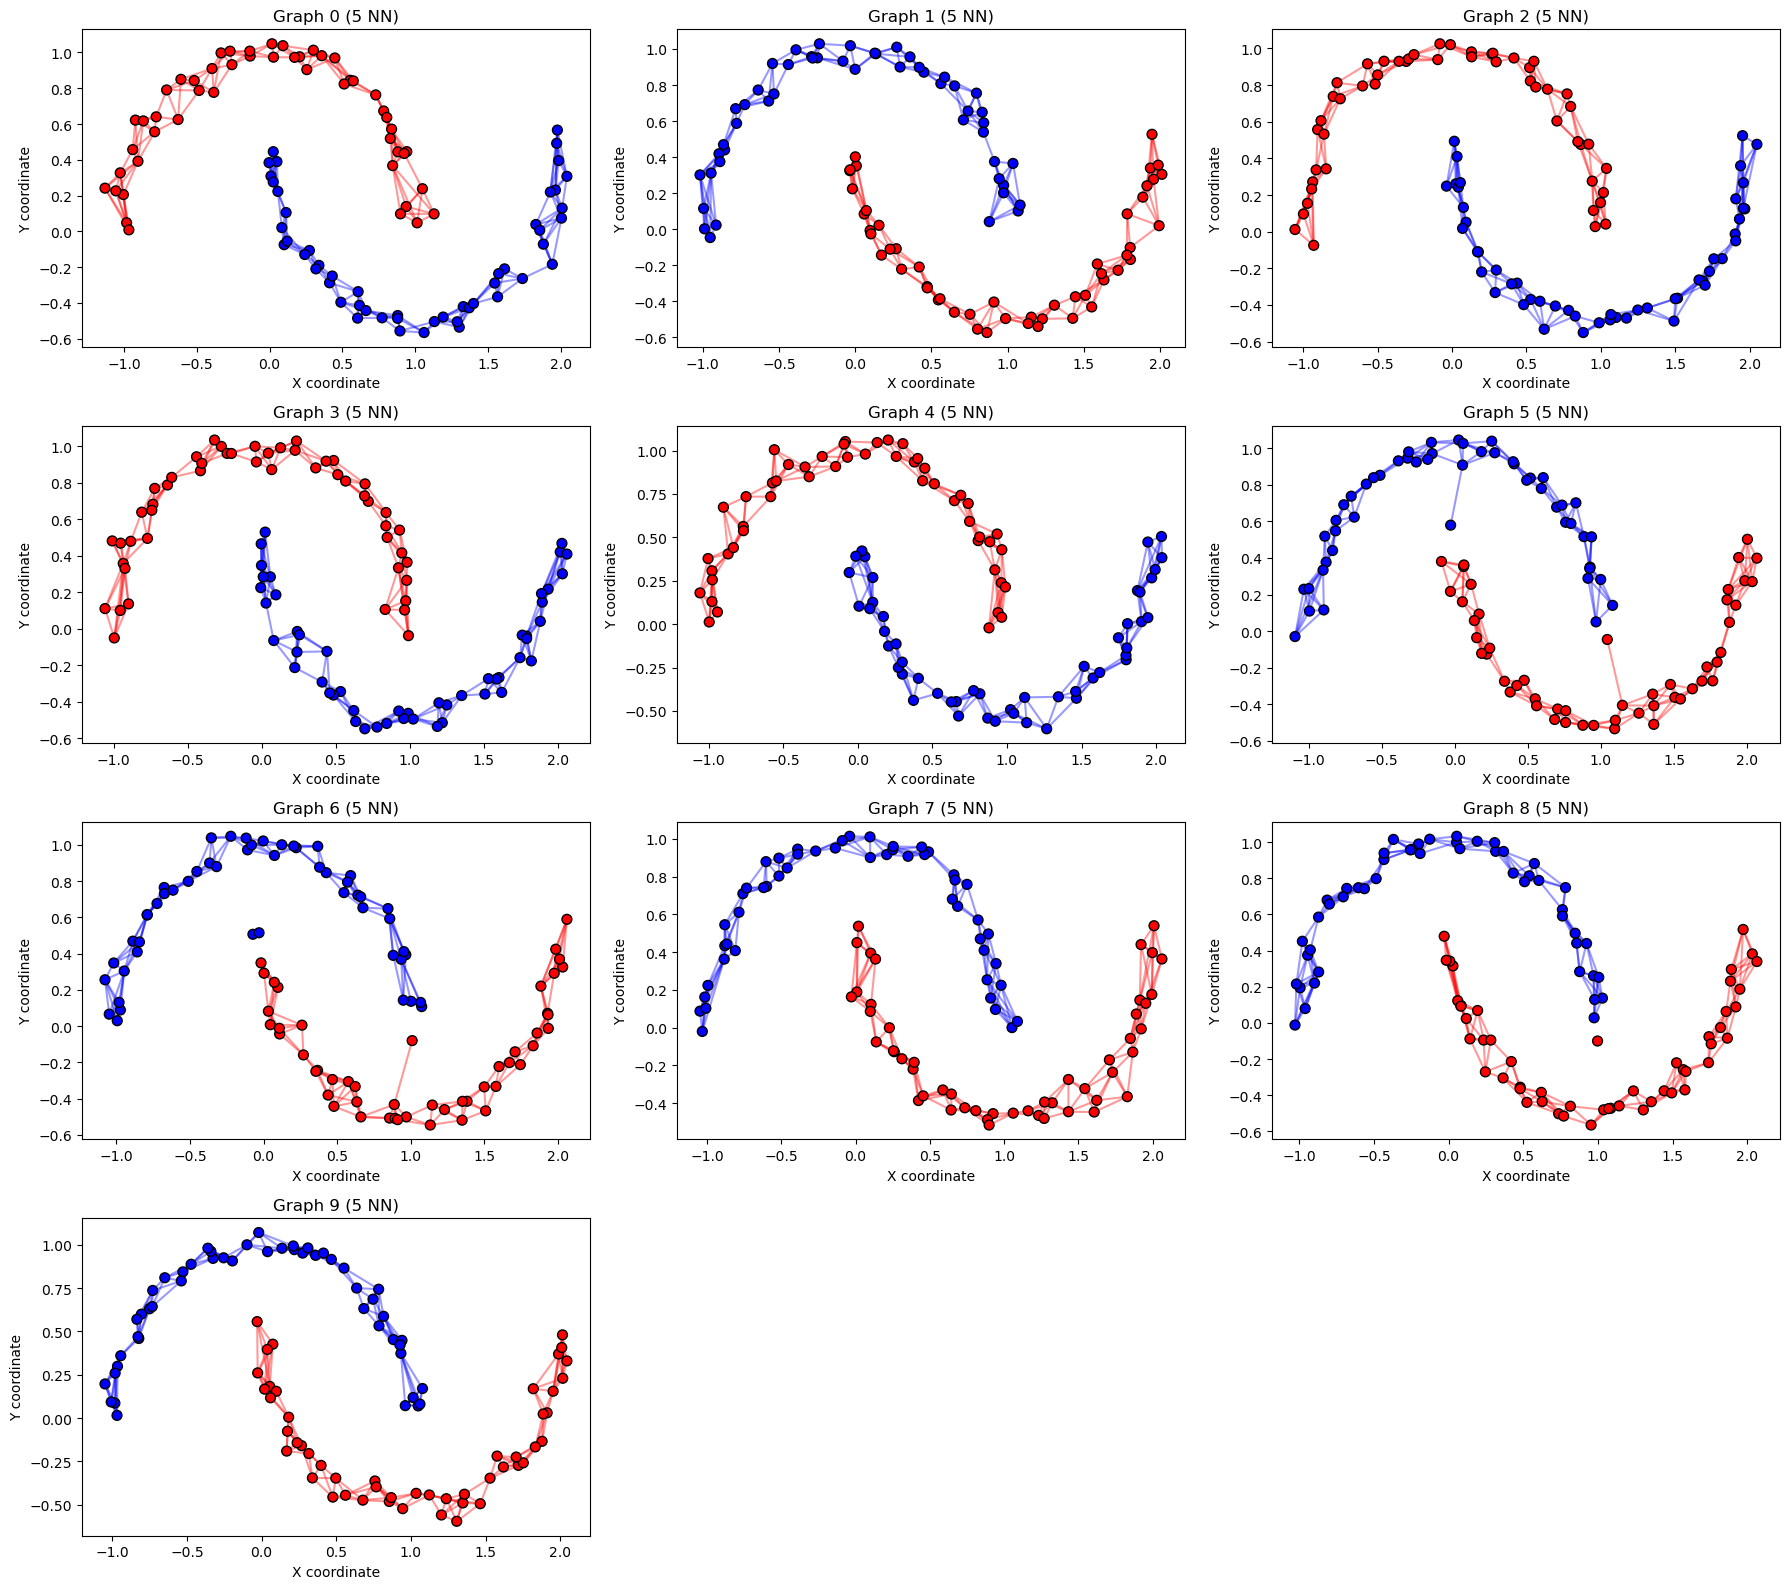

In [110]:
plot_clusters_multi(single_view_graph_X, single_view_graph)

## Global实现

In [119]:
def global_graph_learning(S_list, c, gamma=1.0, max_iter=100, tol=1e-4):
    """
    Input:
        S_list  : a list with each element being a single-view graph (n x n matrix), total of nv views.
        c       : number of clusters (global graph A should have exactly c connected components).
        gamma   : trade-off parameter in the global graph objective function.
        max_iter: maximum number of iterations.
        tol     : tolerance for convergence.

    Output:
        A       : the learned global graph (n x n matrix)
        P       : spectral embedding matrix (n x c matrix)
        W       : weight matrix (nv x n) where each column corresponds to the weights for each view for a data point.
    """
    nv = len(S_list)  # number of views
    n = S_list[0].shape[0]  # number of data points

    # Initialize: set all view weights for each data point to 1/nv
    W = np.full((nv, n), 1.0 / nv)

    # Initialize the global graph A using the weighted-sum rule from S_list
    A = np.zeros((n, n))
    for j in range(n):
        # For the j-th column corresponding to data point j
        a_j = np.zeros(n)
        for v in range(nv):
            a_j += W[v, j] * S_list[v][:, j]
        A[:, j] = a_j
    # Enforce symmetry for A
    A = (A + A.T) / 2

    # Compute the initial Laplacian and spectral embedding matrix P
    L = compute_laplacian(A)
    P, eigvals = update_Q(L, c)

    # Main iterative process
    for it in tqdm(range(max_iter), desc="Global Graph Learning"):
        A_old = A.copy()

        # =============================
        # 1. Update the global graph A: update each column a_j for data point j
        # =============================
        for j in range(n):
            # Compute h_j, where h_j[i] = ||P[i, :] - P[j, :]||^2
            p_j = P[j, :]
            h_j = np.sum((P - p_j)**2, axis=1)
            # Compute the weighted sum from single-view graphs: s_bar = sum_v W[v, j] * S_list[v][:, j]
            s_bar = np.zeros(n)
            for v in range(nv):
                s_bar += W[v, j] * S_list[v][:, j]
            # Construct the updating vector v_vec = s_bar - (gamma/2)*h_j
            v_vec = s_bar - (gamma / 2.0) * h_j
            # Update a_j by projecting v_vec onto the probability simplex
            A[:, j] = project_simplex(v_vec)

        # Enforce symmetry for A
        A = (A + A.T) / 2

        # =============================
        # 2. Update the spectral embedding matrix P
        # =============================
        L = compute_laplacian(A)
        P, eigvals = update_Q(L, c)

        # Check condition: if the Laplacian L has at least c zero eigenvalues, we assume the ideal graph structure is reached.
        num_zero_eig = np.sum(eigvals < 1e-5)
        if num_zero_eig >= c:
            tqdm.write(f"Converged at iteration {it}: {num_zero_eig} zero eigenvalues (>= {c}).")
            break

        # =============================
        # 3. Update the weight matrix W
        # For each data point j, update its view weights based on the difference between A and each S_list[:, j].
        # =============================
        for j in range(n):
            # Construct matrix Z_j of size n x nv: the v-th column is A[:, j] - S_list[v][:, j]
            Z_j = np.column_stack([A[:, j] - S_list[v][:, j] for v in range(nv)])
            M = np.dot(Z_j.T, Z_j)  # size nv x nv
            # Add a small regularizer for numerical stability
            reg = 1e-8 * np.eye(nv)
            try:
                M_inv = np.linalg.inv(M + reg)
            except np.linalg.LinAlgError:
                M_inv = np.linalg.pinv(M + reg)
            ones = np.ones((nv, 1))
            w_j = np.dot(M_inv, ones)
            w_j = w_j / np.sum(w_j)  # normalize so the sum equals 1
            # Update the j-th column of weight matrix W
            for v in range(nv):
                W[v, j] = w_j[v, 0]

        # Optionally: check if A has converged by monitoring relative change
        if np.linalg.norm(A - A_old, 'fro') / np.linalg.norm(A_old, 'fro') < tol:
            tqdm.write(f"A converged at iteration {it} with relative change below {tol}.")
            break

    return A



用所有的single view graph来做global graph

In [134]:
class_number = 2

global_graph = global_graph_learning(single_view_graph, class_number)

Global Graph Learning:   9%|▉         | 9/100 [00:00<00:02, 39.56it/s]

Converged at iteration 9: 2 zero eigenvalues (>= 2).


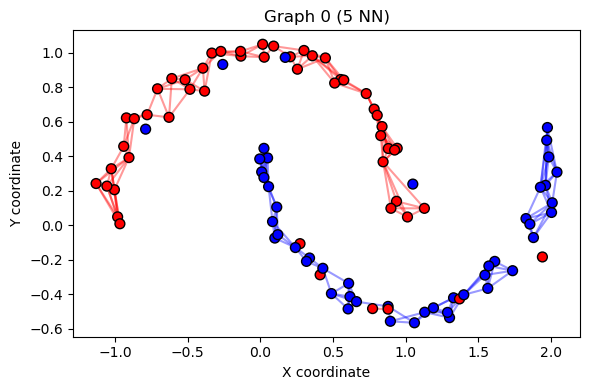

In [135]:
plot_clusters_multi([single_view_graph_X[0]],[global_graph])

用1和7做global

In [131]:
global_graph = global_graph_learning([single_view_graph[0],single_view_graph[6]], class_number)

Global Graph Learning:   1%|          | 1/100 [00:00<00:02, 38.00it/s]

Converged at iteration 1: 2 zero eigenvalues (>= 2).


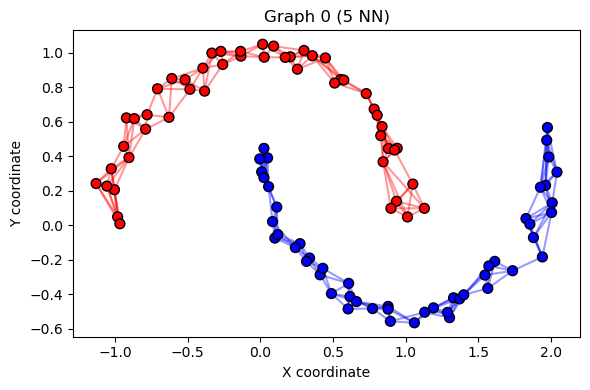

In [132]:
plot_clusters_multi([single_view_graph_X[0]],[global_graph])

## 以下忽略

In [114]:
if __name__ == '__main__':
    # =============================
    # Construct example data using the two-moons dataset from make_moons.
    # For demonstration, use 3 views.
    # =============================
    graph_number = 3  # suppose we have 3 views
    single_view_graph_X = []
    for i in range(graph_number):
        # Generate two-moons data with 100 samples; noise varies slightly per view.
        X, y = make_moons(n_samples=100, noise=0.05 + 0.01 * i, random_state=i+10)
        single_view_graph_X.append(X)

    # For simplicity, we simulate the single-view graph construction (as done in your original update_S function).
    # Here we use the original point set to build a single-view graph S.
    def update_S_from_points(X, beta=1.0):
        """
        Given data points X (n x d), construct a single-view graph S
        based on the Euclidean distances (in the original space).
        """
        n = X.shape[0]
        S = np.zeros((n, n))
        # Compute squared Euclidean distances between points
        X_norms = np.sum(X**2, axis=1, keepdims=True)
        dist_sq = X_norms + X_norms.T - 2 * np.dot(X, X.T)
        dist_sq = np.maximum(dist_sq, 0)
        for j in range(n):
            g_j = dist_sq[:, j]
            v = -g_j / (2 * beta)
            s_j = project_simplex(v)
            S[:, j] = s_j
        return S

    # Use update_S_from_points to generate each view's single-view graph S.
    S_list = []
    beta = 1.0
    for X in single_view_graph_X:
        S = update_S_from_points(X, beta=beta)
        S = (S + S.T) / 2  # ensure symmetry
        S_list.append(S)

    # Suppose the target number of clusters (for two-moons data there are 2 clusters)
    class_number = 2

    # Call the global graph learning function
    gamma = 1.0
    max_iter = 50
    A_global, P_global, W = global_graph_learning(S_list, c=class_number, gamma=gamma, max_iter=max_iter)

    # Print result, for example view the first 10 eigenvalues of the global Laplacian matrix.
    L_global = compute_laplacian(A_global)
    eigvals_global, _ = eigh(L_global)
    print("First 10 eigenvalues of the global Laplacian matrix:", eigvals_global[:10])

    # Visualize the global graph (e.g., using a heatmap)
    plt.figure(figsize=(6, 5))
    plt.imshow(A_global, cmap='hot', interpolation='nearest')
    plt.title("Global Graph A")
    plt.colorbar()
    plt.show()

Global Graph Learning: 100%|██████████| 50/50 [00:00<00:00, 74.57it/s]


ValueError: too many values to unpack (expected 3)